In [1]:
#Some test to exxtract stanford dataset

In [2]:
import obspy

In [3]:
import pandas as pd
import numpy as np

df_test = pd.read_csv("csvs/chunk5.csv")

#df_test.set_index('trace_name',inplace= True)

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
import librosa

In [5]:
min(df_test['source_distance_km'])

df_test_closest = df_test[df_test['source_distance_km'] == min(df_test['source_distance_km'])]

In [6]:
df_test_closest

,network_code,receiver_code,receiver_type,receiver_latitude,receiver_longitude,receiver_elevation_m,p_arrival_sample,p_status,p_weight,p_travel_sec,...,source_magnitude_author,source_mechanism_strike_dip_rake,source_distance_deg,source_distance_km,back_azimuth_deg,snr_db,coda_end_sample,trace_start_time,trace_category,trace_name
33434,GS,KAN08,HH,37.22672,-97.970947,375.0,400.0,manual,0.63,0.78,...,ISMP,None,0.0004,0.04,166.8,[54.40000153 51.5 48.40000153],[[1052.]],2015-04-08 00:54:00.800000,earthquake_local,KAN08.GS_20150408005359_EV


In [7]:
import h5py
hf = h5py.File('chunk5.hdf5', 'r', libver='earliest')

In [8]:
#eread = pd.read_hdf('chunk5.hdf5')

In [15]:
#hf['Folder'].attrs.keys()

#ee = hf.get('data/HPC.NC_20130403221010_EV')
ee = hf.get('data/KAN08.GS_20150408005359_EV')


In [10]:
def normalize(infile, rms_level=0):
    """
    Normalize the signal given a certain technique (peak or rms).
    Args:
        - infile    (str) : input filename/path.
        - rms_level (int) : rms level in dB.
    """
    # read input file
    fs, sig = read_file(filename=infile)

    # linear rms level and scaling factor
    r = 10**(rms_level / 10.0)
    a = np.sqrt( (len(sig) * r**2) / np.sum(sig**2) )

    # normalize
    y = sig * a

    # construct file names
    output_file_path = os.path.dirname(infile)
    name_attribute = "output_file.wav"

    # export data to file
    write_file(output_file_path=output_file_path,
               input_file_name=infile,
               name_attribute=name_attribute,
               sig=y,
               fs=fs)

array([ 0.        ,  0.04376634,  0.11904569, ..., -0.02406796,
       -0.0031936 , -0.        ], dtype=float32)

In [17]:
import soundfile as sf


sf.write('test_raw_waveform.wav', ee[:,2], 100)

In [8]:
ee.attrs.keys()

<KeysViewHDF5 ['back_azimuth_deg', 'coda_end_sample', 'network_code', 'p_arrival_sample', 'p_status', 'p_travel_sec', 'p_weight', 'receiver_code', 'receiver_elevation_m', 'receiver_latitude', 'receiver_longitude', 'receiver_type', 's_arrival_sample', 's_status', 's_weight', 'snr_db', 'source_depth_km', 'source_depth_uncertainty_km', 'source_distance_deg', 'source_distance_km', 'source_error_sec', 'source_gap_deg', 'source_horizontal_uncertainty_km', 'source_id', 'source_latitude', 'source_longitude', 'source_magnitude', 'source_magnitude_author', 'source_magnitude_type', 'source_mechanism_strike_dip_rake', 'source_origin_time', 'source_origin_uncertainty_sec', 'trace_category', 'trace_name', 'trace_start_time']>

Build up velocity
https://docs.obspy.org/contents.html

In [11]:
import obspy
#import h5py
from obspy import UTCDateTime
import numpy as np
from obspy.clients.fdsn.client import Client
import matplotlib.pyplot as plt

def make_stream(dataset):
    '''
    input: hdf5 dataset
    output: obspy stream

    '''
    data = np.array(dataset)

    tr_E = obspy.Trace(data=data[:, 0])
    tr_E.stats.starttime = UTCDateTime(dataset.attrs['trace_start_time'])
    tr_E.stats.delta = 0.01
    tr_E.stats.channel = dataset.attrs['receiver_type']+'E'
    tr_E.stats.station = dataset.attrs['receiver_code']
    tr_E.stats.network = dataset.attrs['network_code']

    tr_N = obspy.Trace(data=data[:, 1])
    tr_N.stats.starttime = UTCDateTime(dataset.attrs['trace_start_time'])
    tr_N.stats.delta = 0.01
    tr_N.stats.channel = dataset.attrs['receiver_type']+'N'
    tr_N.stats.station = dataset.attrs['receiver_code']
    tr_N.stats.network = dataset.attrs['network_code']

    tr_Z = obspy.Trace(data=data[:, 2])
    tr_Z.stats.starttime = UTCDateTime(dataset.attrs['trace_start_time'])
    tr_Z.stats.delta = 0.01
    tr_Z.stats.channel = dataset.attrs['receiver_type']+'Z'
    tr_Z.stats.station = dataset.attrs['receiver_code']
    tr_Z.stats.network = dataset.attrs['network_code']

    stream = obspy.Stream([tr_E, tr_N, tr_Z])

    return stream

In [12]:

client = Client("IRIS")
inventory = client.get_stations(network=ee.attrs['network_code'],
                                station=ee.attrs['receiver_code'],
                                starttime=UTCDateTime(ee.attrs['trace_start_time']),
                                endtime=UTCDateTime(ee.attrs['trace_start_time']) + 60,
                                loc="*", 
                                channel="*",
                                level="response")  


In [1]:
#http://eqseis.geosc.psu.edu/cammon/HTML/Classes/IntroQuakes/Notes/seismometers.html

In [13]:
st = make_stream(ee)
#st = st.remove_response(inventory=inventory, output='VEL', plot=False) 

# ploting the verical component
#make_plot(st[2], title='Velocity', ylab='meters/second')

Compression, amplitude normalization:
https://librosa.org/doc/main/generated/librosa.effects.time_stretch.html
https://superkogito.github.io/blog/rmsnormalization.html

https://docs.obspy.org/packages/autogen/obspy.core.trace.Trace.remove_response.html

In [14]:
type(st)

obspy.core.stream.Stream

In [16]:
st.write('seismic_sound_test.wav',format = 'WAV',framerate = 100)

https://docs.obspy.org/tutorial/code_snippets/filtering_seismograms.html

In [12]:
base_seismogram  = st[2]

In [2]:
filtered_seismogram = st[2].filter("highpass", freq=0.5)


NameError: name 'st' is not defined

In [14]:
st[2].filter("highpass", freq=0.5).data.shape
#.spectrogram(log = True)

(6000,)

from pydub import AudioSegment
from pydub.playback import play

song = AudioSegment.from_wav("seismic_sound_test002.wav")
play(song)


<ipython-input-17-8528c0c08f10>:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(t, f, np.log10(Sxx))


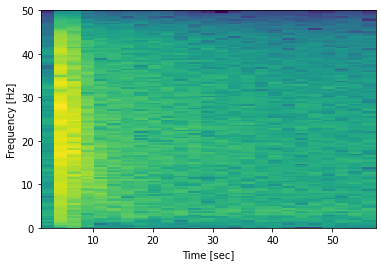

In [17]:
from scipy import signal

f, t, Sxx = signal.spectrogram(st[2].filter("highpass", freq=0.5).data, 100)
plt.pcolormesh(t, f, np.log10(Sxx))
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')

filtered_spectrogram = plt
#plt.savefig
#plt.show()

<ipython-input-16-704b77e9e683>:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  type(plt.pcolormesh(t, f, np.log10(Sxx)))


matplotlib.collections.QuadMesh

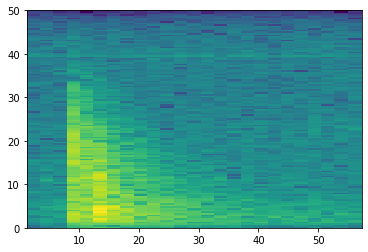

In [16]:
type(plt.pcolormesh(t, f, np.log10(Sxx)))

In [17]:
Sxx.shape

(129, 26)

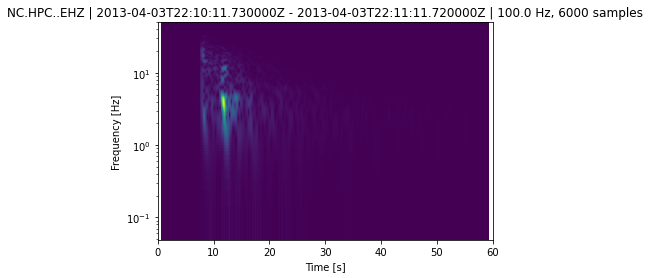

In [18]:
seis_spectrogram = st[2].filter("highpass", freq=0.5).spectrogram(log = True)

In [19]:
type(seis_spectrogram)

NoneType

In [20]:
from io import BytesIO
import base64
def fig_to_uri(in_fig, close_all=True, **save_args):
    # type: (plt.Figure) -> str
    """
    Save a figure as a URI
    :param in_fig:
    :return:
    """
    out_img = BytesIO()
    in_fig.savefig(out_img, format='png', **save_args)
    if close_all:
        in_fig.clf()
        plt.close('all')
    out_img.seek(0)  # rewind file
    encoded = base64.b64encode(out_img.read()).decode("ascii").replace("\n", "")
    #return encoded
    return "data:image/png;base64,{}".format(encoded)

In [32]:
from io import BytesIO
import base64
from scipy import signal
def spectrogram_to_uri(input_data, close_all=True, **save_args):    
    f, t, Sxx = signal.spectrogram(input_data.filter("highpass", freq=0.5).data, 100)
    plt.pcolormesh(t, f, np.log10(Sxx))
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')


    # type: (plt.Figure) -> str
    """
    Save a figure as a URI
    :param in_fig:
    :return:
    """
    out_img = BytesIO()
    plt.savefig(out_img, format='png', **save_args)
    if close_all:
        plt.clf()
        plt.close('all')
    out_img.seek(0)  # rewind file
    encoded = base64.b64encode(out_img.read()).decode("ascii").replace("\n", "")
    #return encoded
    return "data:image/png;base64,{}".format(encoded)

In [21]:
import matplotlib.pyplot as plt

In [22]:
filtered_spectrogram.savefig('test_specgram.png')

<Figure size 432x288 with 0 Axes>

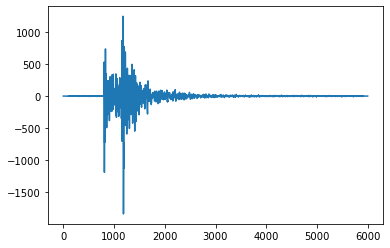

In [23]:
plt.plot(ee[:,2])

E,N,Z channels

[Text(0.5, 1.0, 'Mel-frequency spectrogram')]

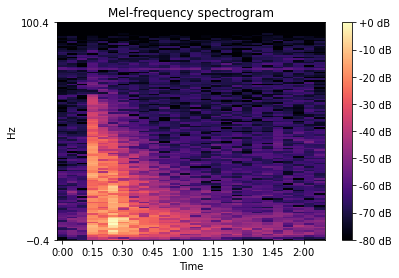

In [24]:
import librosa
import librosa.display
#TODO: convert to spectrogram
fig, ax = plt.subplots()
#S = librosa.feature.melspectrogram(y=ee[:,1], sr=100, n_mels=128,fmax=50)

#S_dB = librosa.power_to_db(np.abs(S), ref=np.max)
#S_dB = librosa.power_to_db(np.abs(librosa.stft(y=ee[:,0])), ref=np.max)
S_dB = librosa.power_to_db(np.abs(Sxx), ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time',
                               y_axis='mel', sr=100,
                               fmax=100, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')

In [25]:
filtered_spectrogram = fig

In [26]:
df_test['time'] = pd.to_datetime(df_test['trace_start_time'], infer_datetime_format=True)
df_test['source_depth_km'] = pd.to_numeric(df_test['source_depth_km'],errors='coerce')
df_test['source_magnitude'] = pd.to_numeric(df_test['source_magnitude'],errors='coerce')
#df_test['source_magnitude'].sort_values()
#df_test.head(2)

In [27]:
df_test = df_test[['time','source_depth_km','source_magnitude','trace_name','source_latitude','source_longitude','trace_category']]

Extract the minimum depth, magnitude, recording times etcc

In [28]:
#Latitudes and longitudes
site_lat = df_test.source_latitude
site_lon = df_test.source_longitude
hover_desc = 'Timestamp: ' +  str(df_test.time) + '<br>Category: ' + df_test.trace_category
#hover_desc = f'Time of registration: {df_earthquake_detections.trace_start_time} <br> Category: {df_earthquake_detections.trace_category}'
#time = df_earthquake_detections.trace_start_time
#ctg =df_earthquake_detections.trace_category
#locations_name = df.text
#min timestamp
#Extract timestamp range
min_date = min(df_test['time']).date()
max_date = max(df_test['time']).date()
#Extract minimum and maximum depth
min_depth = min(df_test['source_depth_km'])
max_depth = max(df_test['source_depth_km'])
#Extract minimum and maximum magnitude
min_magnitude = min(df_test['source_magnitude'])
max_magnitude = max(df_test['source_magnitude'])

depth_space = np.linspace(start=min_depth,stop=max_depth,num=8,endpoint=True,dtype=np.float64)
magnitude_space = np.linspace(start=min_magnitude,stop=max_magnitude,num=8,endpoint=True,dtype=np.float64)

In [29]:
#df_earthquake_detections


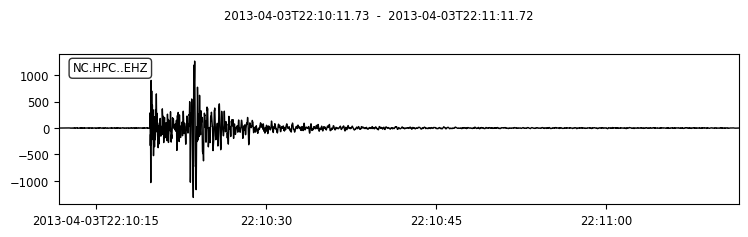

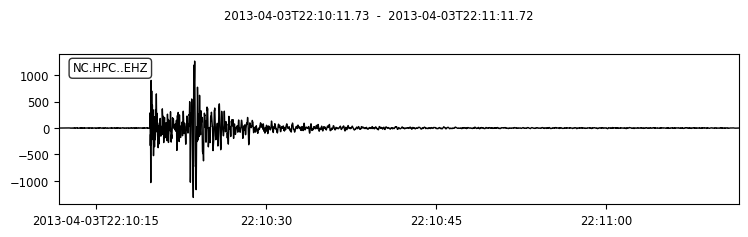

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on


<ipython-input-32-36ae01439e34>:6: MatplotlibDeprecationWarning:

shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.



In [34]:
import base64
import plotly.graph_objects as go
import dash
import dash_core_components as dcc
import dash_html_components as html
import plotly.express as px

import dash_bootstrap_components as dbc
#from dash import  dash_table
import dash_table
from datetime import date
from dash.dependencies import Input,Output,State
from dash import callback_context
#https://plotly.com/python-api-reference/generated/plotly.graph_objects.Scattermapbox.html
#https://community.plotly.com/t/scattermapbox-setting-visible-range/6140/3
#mapbox_access_token = open(".mapbox_token").read()

'''
mapbox_access_token = "pk.eyJ1IjoiZG9yYW5kMzIiLCJhIjoiY2t6OG81a3lnMHhnNjJ2czhkaTg2cGRreiJ9.50gnwHchu58S-KeK0fW8Ig"
#Mapbox map initialize


fig = go.Figure({"layout": {
    "title": "My Dash Graph",
    "height": 700,  # px
}})
fig.add_trace(go.Scattermapbox(
    lat=site_lat,
    lon=site_lon,
    mode='markers',
    marker=go.scattermapbox.Marker(
        #TODO: size might be affected by strength of the event
        size=17,
        #TODO: if we have other events which differs from local earthquake, other color would be assigned
        color='rgb(255, 0, 0)',
        opacity=0.7
    ),
    text=hover_desc,
    #hoverinfo='text'
    #hovertemplate=f'<i>Average Stage</i>: %{time}'+
    #              '<br><b>Average Discharge</b>: %{ctg}<br>',
    hoverinfo='text'
))
fig.update_layout(
    title='Idea for plotting earthquake events',
    autosize=True,
    hovermode='closest',
    showlegend=False,
    mapbox=dict(
        accesstoken=mapbox_access_token,
        bearing=0,
        center=dict(
            lat=38,
            lon=-94
        ),
        pitch=0,
        zoom=1,
        #minzoom = 1,
        style='light'
    ),
)
#df = px.data.gapminder().query("year == 2007")
'''



#!!!!!!!!!!!!!https://github.com/Coding-with-Adam/Dash-by-Plotly/blob/master/Dash_Interactive_Graphs/Scatter_mapbox/recycling.py
app = dash.Dash()


image_filename = 'samples_for_wireframe/map_screenshot.PNG'
encoded_image = base64.b64encode(open(image_filename, 'rb').read())
#app.layout =html.Div([
app.layout = html.Div([dbc.Row([

                                #Filters
                                html.Div(style={'width':'20%','marginLeft': 5, 'marginRight': 10,'display':'inline-block',"border":"2px black solid",'vertical-align': 'top'},
                                         children = [
                                            #html.Div([
                                            # dcc.Graph: maybe define somehow here?
                                            #dcc.Graph(figure=fig, id='map-layout')]),
                                             #'width':'15%','marginLeft': 20, 'marginRight': 20,
                                            html.Div(style={ 'display': 'block','vertical-align':'middle'},
                                                     children = [
                                                        html.Br(),
                                                        html.H3('Select a date interval'),
                                                        html.Br(),
                                                    #Datepicker to filter for intervals
                                                        dcc.DatePickerRange(
                                                            id='date-filter',
                                                            #min_date_allowed=date(1993, 1, 10),
                                                            min_date_allowed=min_date,
                                                            max_date_allowed=max_date,
                                                            #max_date_allowed=date(2019, 9, 19),
                                                            initial_visible_month=min_date,
                                                            start_date=min_date,
                                                            end_date=max_date
                                                        )]),
                                            #'width':'15%','marginLeft': 20, 'marginRight': 20,'marginTop':30,
                                            html.Div(
                                                style={ 'display': 'block','vertical-align':'middle'},
                                                children = [
                                                html.Br(),
                                                html.H3('Select earthquake depth interval ( in km)'),
                                                html.Br(),
                                                #slider to filter for depth
                                                dcc.RangeSlider(min = min_depth, max = max_depth,
                                                                id='depth-slider',
                                                                marks={i: '{:.2f}'.format(i) for i in depth_space},
                                                                value=[min_depth, max_depth],
                                                                dots=False,
                                                                #step=
                                                                step=0.01,
                                                                updatemode='drag',
                                                                tooltip={"placement": "bottom", "always_visible": False}
                                            )]),
                                             #'width':'15%','marginLeft': 20, 'marginRight': 20,'marginTop':30,
                                            html.Div(
                                                style={'display': 'block','vertical-align':'middle'},
                                                children = [
                                                html.Br(),
                                                html.H3('Select earthquake magnitude interval ( in km)'),
                                                html.Br(),
                                                #slider to filter for magnitudes
                                                dcc.RangeSlider(min = min_magnitude, max = max_magnitude,
                                                                id='magnitude-slider',
                                                                marks={i: '{:.2f}'.format(i) for i in magnitude_space},
                                                                value=[min_magnitude, max_magnitude],
                                                                dots=False,
                                                                step=0.01,
                                                                updatemode='drag',
                                                                tooltip={"placement": "bottom", "always_visible": False}
                                                                ),
                                                ]),
                                             html.Div(
                                                 style={'display': 'block','vertical-align':'middle'},
                                                 children = [
                                                             html.Button('Apply Filter', id='filter-apply-btn', n_clicks=0),
                                                             html.Button('Reset Filter', id='filter-reset-btn', n_clicks=0)]
                                             )
                                         ]),
                                #Map
                                html.Div(
                                        style={'width':'75%', 'marginRight': 5,'display':'inline-block',"border":"2px black solid"},
                                        #children = [dcc.Graph(figure=fig, id='map-layout')])]
                                        children = [html.Img(src ='data:image/png;base64,{}'.format(encoded_image.decode()))])]
                                       # children = [ dash_table.DataTable(data = df_test.head(5).to_dict('records'),columns=[{"name": i, "id": i} for i in df_test.columns], id='tbl')])]
                                ),
                dbc.Row(html.Div([
                    #Audio player
                    html.Div(style={'width':'20%','marginLeft': 5,'marginTop': 20, 'marginRight': 20,'display':'inline-block',"border":"2px black solid",'vertical-align': 'top'},
                             children = [html.Audio(src='samples_for_wireframe/HC1.wav', controls=True)]),
                    #Spectrogram
                    html.Div(style={'width':'75%', 'marginRight': 10 ,'marginTop': 20, 'display':'inline-block',"border":"2px black solid"},
                             #children = [html.Img(src='samples_for_wireframe/img.png')])]))])
                             children = [html.Div(style={ 'display': 'block','vertical-align':'middle'},id = 'seismogram-div', children = [html.Img(src = fig_to_uri(base_seismogram.plot()))]),
                                         html.Div(style={ 'display': 'block','vertical-align':'middle'},id = 'filtered_seismogram-div', children = [html.Img(src = fig_to_uri(filtered_seismogram.plot()))]),
                                         html.Div(style={ 'display': 'block','vertical-align':'middle'},id = 'spectrogram-div', children = [html.Img(src = spectrogram_to_uri(st[2]))])
                                         #html.Div(style={ 'display': 'block','vertical-align':'middle'},id = 'spectrogram-div', children = [html.Img(src = fig_to_uri(filtered_spectrogram))])                                                                                                                        
                                        ])]))])

@app.callback(
    #Output(component_id='tbl', component_property='data'), #Output will be the table (later map)
    Output(component_id='depth-slider', component_property= 'value'),
    Output(component_id='magnitude-slider', component_property= 'value'),
    Output(component_id='date-filter', component_property= 'start_date'),
    Output(component_id='date-filter', component_property= 'end_date'),
    Input(component_id='filter-apply-btn', component_property='n_clicks'), #Input button triggers the callback
    Input(component_id='filter-reset-btn', component_property='n_clicks'), #Input button triggers the callback
    State(component_id='depth-slider', component_property= 'value'),
    State(component_id='magnitude-slider', component_property= 'value'),
    State(component_id='date-filter', component_property= 'start_date'),
    State(component_id='date-filter', component_property= 'end_date')

)
def apply_filter(apply_click,reset_click, depth_value, magnitude_value,start_date,end_date):
    ctx = dash.callback_context
    clicked_element = ctx.triggered[0]['prop_id'].split('.')[0]
    if  clicked_element == 'filter-apply-btn':
        filter_records = df_test['time'].between(pd.to_datetime(start_date),pd.to_datetime(end_date)) & df_test['source_magnitude'].between(magnitude_value[0],magnitude_value[1])\
                         & df_test['source_depth_km'].between(depth_value[0],depth_value[1])
        df_filtered = df_test[filter_records]
        return [depth_value,magnitude_value,start_date,end_date]
        #return [df_filtered.head(5).to_dict('records'),depth_value,magnitude_value,start_date,end_date]

    elif clicked_element == 'filter-reset-btn':
        return [[min_depth,max_depth],[min_magnitude,max_magnitude],min_date,max_date]
       # return [df_test.head(5).to_dict('records'),[min_depth,max_depth],[min_magnitude,max_magnitude],min_date,max_date]

    else:
        return dash.no_update


'''
selection of earthquake events on maps
First, selection in the table will be used as test for composition,
then refactor for map event selection
'''

app.run_server(debug=True, use_reloader=False)  # Turn off reloader if inside Jupyter


If we also want to load map, that need to be used